## Cancer detection Using CNN (Keras)

## Introduction

Medical imaging is big business these days. And so is the image classification that comes with it. In 2021 image recognition software raken in a whopping 30 billion dollars.(*)
So if a random person can make such an algorithm for free or no little cost. Why not have them do it.


https://www.altamira.ai/blog/image-re%D1%81ognition-cost/(*)

The aim of this project is to identify cancer using very small patches taken from bigger patches of an image. It is supposed to be fine enough to detect cancer in 1 pixel. The train set contains about 220,000 images, the test set contains about 57,000.


In [1]:
import numpy as np
import pandas as pd
import os
from os import listdir
import cv2

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()
from PIL import Image, ImageDraw
from glob import glob
from skimage.io import imread

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch 
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import TensorDataset, DataLoader, Dataset
import torch.optim as optim
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras_preprocessing.image import ImageDataGenerator
import time
import copy
import tensorflow as tf
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout
from tensorflow.keras.utils import plot_model
from tensorflow.keras.optimizers.legacy import Adam
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", category=FutureWarning)
from datetime import time
from datetime import date
import datetime
import time
from time import mktime
from tqdm.notebook import trange, tqdm

In [2]:

# Device configuration
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
device
torch.cuda.is_available()

device(type='cpu')

In [4]:
base_dir = '../CNN_Cancer_Detection/'
print(os.listdir(base_dir))

['.dist', 'Part1_.ipynb', 'Part1_A.ipynb', 'sample_submission.csv', 'sample_submission.csv (1).zip', 'test', 'test.zip', 'train', 'train.zip', 'train_labels.csv', 'train_labels.csv.zip', 'uhlabels']


# Data loading
The data is split into train data, train labels. I need to load these separately. 

In [5]:
train_labels = pd.read_csv(base_dir+"train_labels.csv/train_labels.csv")
train_labels.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


In [6]:

train_labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


Lets see if there are duplicates. According to the below code, there are not. 

In [7]:
myset = set(train_labels['id'])
len(myset)


220025

In [ ]:
len(train_labels)

In [10]:
train_labels.shape
train_path = (base_dir+"train")
submission_path = (base_dir+"sample_submission.csv")
sub =pd.read_csv(base_dir+"sample_submission.csv/sample_submission.csv")

In [11]:
positive = train_labels[(train_labels['label']==1)]
negative = train_labels[(train_labels['label']==0)]

It is obvious with close inspection that the untrained eye would not be able to discern positive from negative in the below images. 

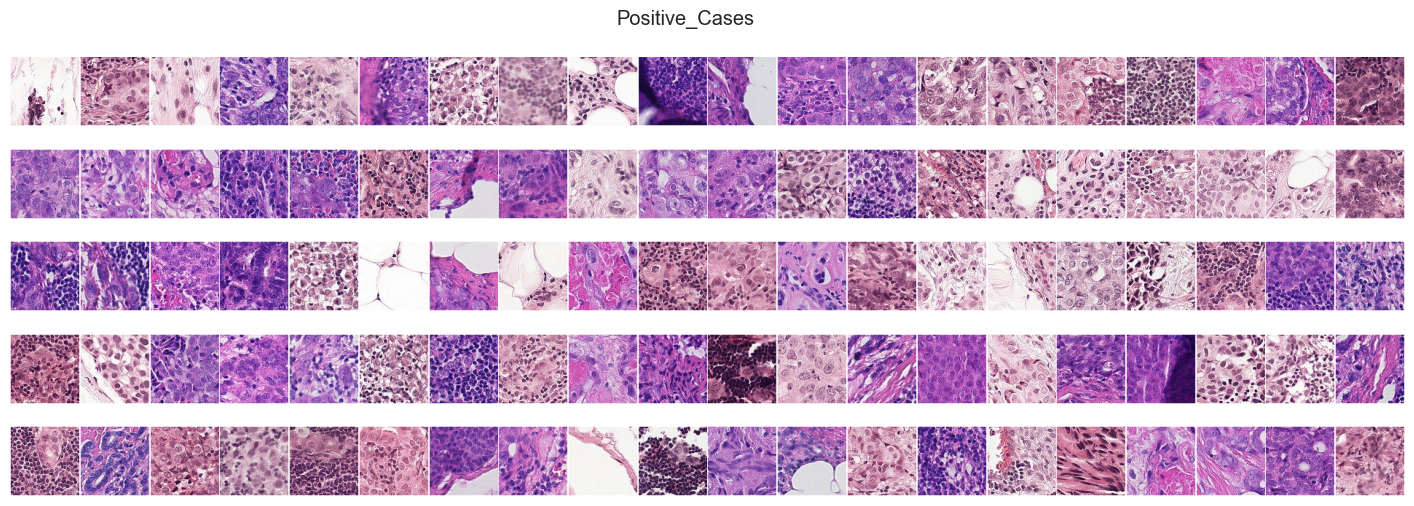

In [12]:

# plotting the images from relevant files. Pretty neat actually. 
fig,ax = plt.subplots(5,20,figsize=(18,6))
plt.subplots_adjust(wspace=0, hspace=0) 
for i,j in enumerate(positive['id'][:5*20]):
    fname = os.path.join(train_path ,j +'.tif').replace("\\","/")
    img = Image.open(fname)
    idcol = ImageDraw.Draw(img)
    idcol.rectangle(((0,0),(95,95)),outline=None)
    plt.subplot(5, 20, i+1) 
    plt.imshow(np.array(img))
    plt.axis('off')
    title = ("Positive_Cases")
    plt.suptitle(title, y=0.94)


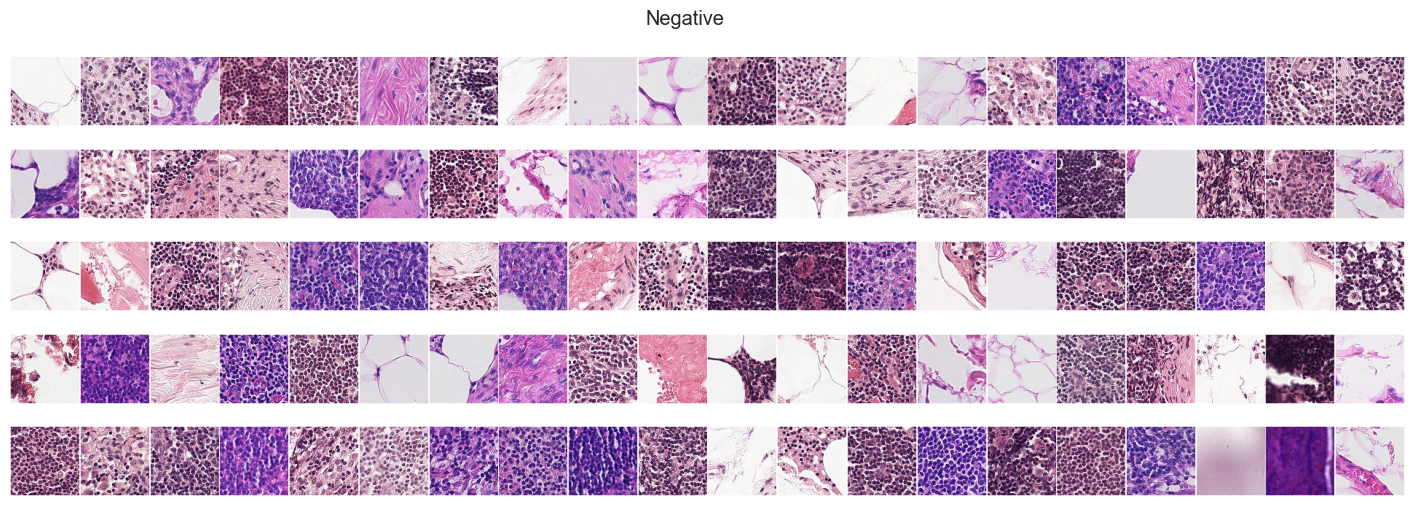

In [14]:

fig,ax = plt.subplots(5,20,figsize=(18,6))
plt.subplots_adjust(wspace=0, hspace=0) 
for i,j in enumerate(negative['id'][:5*20]):
    fname = os.path.join(train_path ,j +'.tif').replace("\\","/")
    img = Image.open(fname)
    idcol = ImageDraw.Draw(img)
    idcol.rectangle(((0,0),(95,95)),outline=None)
    plt.subplot(5, 20, i+1) 
    plt.imshow(np.array(img))
    plt.axis('off')
    title = ("Negative")
    plt.suptitle(title, y=0.94)

In [16]:
positive1 = (positive['label'].value_counts())
negative1 = (negative['label'].value_counts())

In [17]:
positive2 = (positive1)
negative2 = (negative1)
orp = pd.DataFrame(zip(positive2,negative2),columns=['positive','negative'])
sumsq = (orp.sum())
values = ['positive','negative']
datas = [89117,130908]

## Data Plotting
There are about 80,000 positive images and 130,000 negative images according to each of the below visualizations.

<BarContainer object of 2 artists>

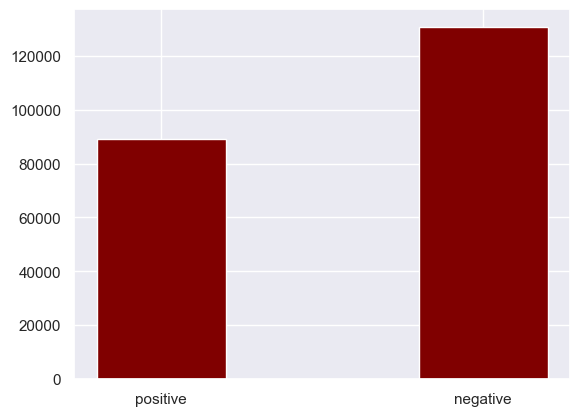

In [19]:
plt.bar(values, datas, color ='maroon',
        width = 0.4)

([<matplotlib.patches.Wedge at 0x17ae9e63dd0>,
 [Text(0.3233411907247941, 1.0514040490604326, 'Positive'),
  Text(-0.3233412891643445, -1.0514040187870408, 'Negative')])

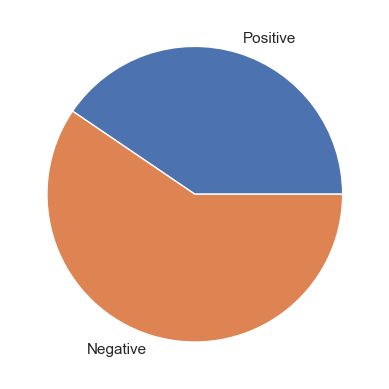

In [20]:
plt.pie(sumsq, labels = ['Positive','Negative'])

Splitting the data
https://pytorch.org/tutorials/beginner/data_loading_tutorial.html for reference
Splitting data into training and validation sets
I am going to use Keras preprocessing 

In [21]:
train, val = train_test_split(train_labels, stratify=train_labels.label, test_size=0.1)
print(len(train), len(val))

198022 22003


,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0
...,...,...
220020,53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
220021,d4b854fe38b07fe2831ad73892b3cec877689576,1
220022,3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0
220023,f129691c13433f66e1e0671ff1fe80944816f5a2,0
